In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import pickle
import math

In [2]:
def loadDataset():
    path = '../../../DataSets/DevanagariHandwrittenCharacterDataset/Train/*'
    train_l = []
    train_d = [] # pixels 32*32
    for label ,folder_name in enumerate(glob.glob(path)):
        for image in (glob.glob(folder_name+'/*')):
            imgdata = plt.imread(image).ravel()  # return (1024,) array  
            train_d.append(imgdata)
            train_l.append(label)
    # takes 20 sec
    
    path = '../../../DataSets/DevanagariHandwrittenCharacterDataset/Test/*'
    test_l = []
    test_d = [] # pixels 32*32
    for label ,folder_name in enumerate(glob.glob(path)):
        for image in (glob.glob(folder_name+'/*')):
            imgdata = plt.imread(image).ravel()  # return (1024,) array  
            test_d.append(imgdata)
            test_l.append(label)
    # takes 10 sec

    return np.vstack(train_d) , np.vstack(test_d) , np.vstack(train_l) , np.vstack(test_l)

(78200, 1024)
(13800, 1024)
(78200, 1)
(13800, 1)


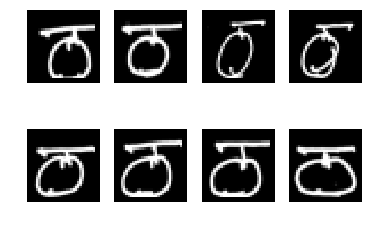

In [5]:
# takes approx. 30sec
X_train , X_test , y_train , y_test = loadDataset()
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

for i in range(1,9):
    plt.subplot(240+i)
    plt.axis('off')
    plt.imshow(X_train[4581+i,:].reshape(32,32), cmap='gray')
plt.show()

In [1]:
# Pass any data set in numpy array form and labels as also
# for example check out the shapes of X_train y_train

In [154]:
class NeuralNetwork():
    
    def __init__(self):
        
        self.layers_n       = [] # no. of layers
        self.theta_layers   = [] # hidden layers weight list
        self.bias           = [] # hidden layers bias list
        self.v0             = [] # exponential weight for momentum it also works as a bias 
        self.vb             = [] # exponential bias
        self.activations    = [] # list of activations
        self.dL_dA          = [] # derivative w.r.t activations
        self.dL_dtheta      = [] # derivative w.r.t weights 
        self.dL_dbias       = [] # derivative w.r.t bias
        self.itera          = [] # store iterations
        self.csfun          = [] # store cost function values
        self.beta           = 0.9 # momentum constant
        
    def add(self , neuron ):
        self.layers_n.append(neuron)
        
    def one_hot_label(self , y):
        one_hot_labels = np.zeros((y.shape[0] , self.layers_n[-1]))
        for i in range(y.shape[0]):  
            one_hot_labels[i, y[i] ] = 1
        return one_hot_labels
    
    def fit(self , X , y , batch_size = 128 , alpha = 0.01 , epoche = 100,lmda = .01):
        # He initialization
        for i in range(len(self.layers_n)-1): 
            self.theta_layers.append(np.random.randn(self.layers_n[i],self.layers_n[i+1]) * np.sqrt(2/self.layers_n[i]))
            self.v0.append(np.zeros([self.layers_n[i],self.layers_n[i+1]])) 
            
            self.bias.append(np.random.randn(self.layers_n[i+1]) * np.sqrt(2/self.layers_n[i]) )
            self.vb.append(np.zeros(self.layers_n[i+1]))
        
        return self.randomMiniBatch( X , y , batch_size , alpha , epoche )
      
    def softmax(self , activation , theta , bias):
        exp = np.exp( np.dot( activation , theta ) + bias)
        denominator = np.sum( exp , axis = 1)
        s = list(map(lambda i : exp[:,i] / denominator , np.arange(self.layers_n[-1])))
        return np.array(s).T
    
    def relu(self,activation,theta, bias):
        q = (np.dot(activation , theta) + bias)
        return np.clip(q , a_min=0 , a_max = q)

    def forwardPropagation(self,X):
        
        self.activations    = []
        
        self.activations.append(X)
        for i in range(len(self.layers_n)-2):
            self.activations.append(self.relu(self.activations[i] , self.theta_layers[i] , self.bias[i]))
                      
        self.activations.append(self.softmax(self.activations[-1] , self.theta_layers[-1] , self.bias[-1]))
        
    def costFunction(self,X,y):
        
        self.y = self.one_hot_label(y)
        self.forwardPropagation(X)
        
        np.nan_to_num(self.activations[-1] , copy = False)
        self.crossEntropy = self.y * np.log(self.activations[-1])
        np.nan_to_num(self.crossEntropy, copy=False)
        
        #regu = self.lmda * (np.sum(self.theta_layer1)**2 + np.sum(self.theta_layer2)**2 + np.sum(self.theta_layer3)**2 + np.sum(self.theta_layer4)**2)
        return (1/X.shape[0] * -np.sum(self.crossEntropy)) #+ regu  # regu = 0 bcz lmda is zero 
      
    
    def backPropagation(self,X,y,alpha):
        
        self.dL_dA          = []
        self.dL_dtheta      = []
        self.dL_dbias       = []
        
        self.forwardPropagation(X)
        
        self.y_cap = self.activations[-1]
        self.target_y = self.one_hot_label(y)
        
        self.dL_dA.append(self.y_cap - self.target_y)
        
        for i in range(len(self.layers_n)-2):   
            
            self.dL_dA.append( np.dot( self.dL_dA[i] , self.theta_layers[-1-i].T ) )
        
        for i in range(len(self.layers_n)-1):  
            
            self.dL_dtheta.append(1/X.shape[0] * (np.dot(self.activations[-2-i].T , self.dL_dA[i]))) 
            self.dL_dbias.append(1/X.shape[0] * self.dL_dA[i])
        
        for i in range(len(self.layers_n)-1):  
             
            self.theta_layers[i]    -= (alpha * self.dL_dtheta[-1-i])  
            self.bias[-1-i]         -= (alpha * self.dL_dbias[i].sum(axis = 0))                  

            
    def randomMiniBatch(self, X, y, batch_size, alpha, epoch = 2):              
        i = 0
        j = 1
        m = X.shape[0]       
       
        while i < epoch:
       
            permutation = list(np.random.permutation(m))
            shuffled_X = X[permutation,:]               # shuffle data
            shuffled_Y = y[permutation].reshape((m,1))
            num_complete_minibatches = math.floor(m/batch_size) 

            # divide whole data into mini batches
            for k in range(0, num_complete_minibatches):
                
                mini_batch_X = shuffled_X[k * batch_size : (k + 1) * batch_size, :]
                mini_batch_Y = shuffled_Y[k * batch_size : (k + 1) * batch_size, :]
                cost = self.costFunction(mini_batch_X , mini_batch_Y )
       
                self.backPropagation(mini_batch_X, mini_batch_Y , alpha )
                    
                print('Iteration {} Cost function {}'.format(j , cost ))    
                
                self.itera.append(j)
                self.csfun.append(cost)
                j +=1 
                
        
            if m % mini_batch_size != 0:
                
                mini_batch_X = shuffled_X[num_complete_minibatches * batch_size: , :]
                mini_batch_Y = shuffled_Y[num_complete_minibatches * batch_size: , :]
                cost = self.costFunction(mini_batch_X , mini_batch_Y )
       
                self.backPropagation(mini_batch_X, mini_batch_Y , alpha )
                    
                print('Iteration {} Cost function {}'.format(j , cost ))    
        
                self.itera.append(j+1)
                self.csfun.append(cost)
            i+=1
            print((i+1)," epoch")
    
    def gradient_plot(self):
        plt.plot(self.itera[10:],self.csfun[10:])
        plt.show()
         
        
    def accuracy(self , X , y):
        self.forwardPropagation(X)
        pred = np.argmax(self.activations[-1],axis=1)
        c1 = 0
        for i,j in enumerate(y):
            if j == pred[i]:
                c1+=1
        print("Accuracy : ",(c1/y.shape[0])*100,'%')    


In [155]:
NN = NeuralNetwork()
NN.add(1024)
NN.add(200)
NN.add(46)
NN.fit(X_train , y_train , batch_size = 512 , alpha = 0.099 ,  epoche = 10)

Iteration 1 Cost function 4.129037060908581
Iteration 2 Cost function 4.137954285047035
Iteration 3 Cost function 3.9943547012207916
Iteration 4 Cost function 4.006011247982059
Iteration 5 Cost function 3.9440289064421923
Iteration 6 Cost function 3.9204498327888824
Iteration 7 Cost function 3.8530553428845913
Iteration 8 Cost function 3.8935375449515033
Iteration 9 Cost function 3.8079610806768796
Iteration 10 Cost function 3.779796017615963
Iteration 11 Cost function 3.719989366027174
Iteration 12 Cost function 3.736349861799728
Iteration 13 Cost function 3.693001229876624
Iteration 14 Cost function 3.661941220638413
Iteration 15 Cost function 3.6257080378491215
Iteration 16 Cost function 3.606449579165031
Iteration 17 Cost function 3.56279692271751
Iteration 18 Cost function 3.5163988720606416
Iteration 19 Cost function 3.5615476171774176
Iteration 20 Cost function 3.511394748439346
Iteration 21 Cost function 3.459840796628428
Iteration 22 Cost function 3.415826794128854
Iteration 2

Iteration 182 Cost function 1.509393570651787
Iteration 183 Cost function 1.476739447746105
Iteration 184 Cost function 1.5916087460470232
Iteration 185 Cost function 1.603917474790825
Iteration 186 Cost function 1.5154628541452215
Iteration 187 Cost function 1.5040459843122602
Iteration 188 Cost function 1.5086429703501367
Iteration 189 Cost function 1.4934575517410082
Iteration 190 Cost function 1.4748229560383521
Iteration 191 Cost function 1.5439054927233151
Iteration 192 Cost function 1.4657085037546764
Iteration 193 Cost function 1.540079656651916
Iteration 194 Cost function 1.4459162396781662
Iteration 195 Cost function 1.5827939256900005
Iteration 196 Cost function 1.5452762717524022
Iteration 197 Cost function 1.502918431577498
Iteration 198 Cost function 1.493506539614613
Iteration 199 Cost function 1.4604916908164722
Iteration 200 Cost function 1.5190739310999835
Iteration 201 Cost function 1.495684891356617
Iteration 202 Cost function 1.326375367733037
Iteration 203 Cost fu

Iteration 359 Cost function 1.3165676609051014
Iteration 360 Cost function 1.2440176298507615
Iteration 361 Cost function 1.295788998281001
Iteration 362 Cost function 1.2111798835486498
Iteration 363 Cost function 1.2781278734335193
Iteration 364 Cost function 1.238648727403446
Iteration 365 Cost function 1.1327185233665875
Iteration 366 Cost function 1.137824283572
Iteration 367 Cost function 1.2738614447591203
Iteration 368 Cost function 1.2851201524814924
Iteration 369 Cost function 1.2561979329180888
Iteration 370 Cost function 1.2173885470737478
Iteration 371 Cost function 1.283802990836457
Iteration 372 Cost function 1.2184435978245687
Iteration 373 Cost function 1.2820215692830828
Iteration 374 Cost function 1.3724305532239036
Iteration 375 Cost function 1.2756867028645864
Iteration 376 Cost function 1.1722318714930509
Iteration 377 Cost function 1.170772157824711
Iteration 378 Cost function 1.2076020775425653
Iteration 379 Cost function 1.1610298592612849
Iteration 380 Cost fu

Iteration 533 Cost function 1.039792329375538
Iteration 534 Cost function 1.1535483193909348
Iteration 535 Cost function 1.097906978899971
Iteration 536 Cost function 1.011006938909485
Iteration 537 Cost function 1.132577610216447
Iteration 538 Cost function 1.2362011798782508
Iteration 539 Cost function 1.1312988876918193
Iteration 540 Cost function 1.1072681805339122
Iteration 541 Cost function 1.0456037638050866
Iteration 542 Cost function 1.0872493799129619
Iteration 543 Cost function 1.17625264062885
Iteration 544 Cost function 1.1630012594357229
Iteration 545 Cost function 1.0042031427149651
Iteration 546 Cost function 1.0456776349689711
Iteration 547 Cost function 1.1894773602243212
Iteration 548 Cost function 1.097200115582296
Iteration 549 Cost function 1.2413398622247995
Iteration 550 Cost function 1.0965364718434665
Iteration 551 Cost function 1.1416017731971386
Iteration 552 Cost function 1.142298785652155
Iteration 553 Cost function 1.1265083657495298
Iteration 554 Cost fu

Iteration 709 Cost function 1.0085509530703116
Iteration 710 Cost function 1.0259761951764712
Iteration 711 Cost function 1.102252797639589
Iteration 712 Cost function 0.9821640020981193
Iteration 713 Cost function 1.0052537505453345
Iteration 714 Cost function 1.052101791026423
Iteration 715 Cost function 1.0587464172697691
Iteration 716 Cost function 1.0363561770632999
Iteration 717 Cost function 1.0496301700284474
Iteration 718 Cost function 0.9976989360094058
Iteration 719 Cost function 0.9958451789763866
Iteration 720 Cost function 1.0983253593641382
Iteration 721 Cost function 1.059999378829628
Iteration 722 Cost function 1.037730162307302
Iteration 723 Cost function 1.1076933309891652
Iteration 724 Cost function 1.069869300411452
Iteration 725 Cost function 1.0758192601842285
Iteration 726 Cost function 1.1204623058423375
Iteration 727 Cost function 1.0739487308979445
Iteration 728 Cost function 1.1148068707143284
Iteration 729 Cost function 1.116399066022209
Iteration 730 Cost 

Iteration 886 Cost function 1.0046589630334517
Iteration 887 Cost function 1.1120781467127006
Iteration 888 Cost function 0.9895847430876162
Iteration 889 Cost function 1.153077006148784
Iteration 890 Cost function 1.0145869075932445
Iteration 891 Cost function 1.0933880135781027
Iteration 892 Cost function 1.041920942776462
Iteration 893 Cost function 1.0274678046306465
Iteration 894 Cost function 0.9952904713771814
Iteration 895 Cost function 1.0679952698008313
Iteration 896 Cost function 1.043457604121051
Iteration 897 Cost function 1.0109287227347061
Iteration 898 Cost function 0.9309527362647194
Iteration 899 Cost function 1.0174093605320715
Iteration 900 Cost function 0.9439784606405155
Iteration 901 Cost function 1.0115393953271288
Iteration 902 Cost function 0.9227741832808822
Iteration 903 Cost function 0.9995160056160831
Iteration 904 Cost function 1.0786367595118245
Iteration 905 Cost function 1.04680758135292
Iteration 906 Cost function 0.9200412335417663
Iteration 907 Cost

Iteration 1059 Cost function 1.0452185606050308
Iteration 1060 Cost function 0.9546814956528079
Iteration 1061 Cost function 0.9928188505131221
Iteration 1062 Cost function 1.0226791341958692
Iteration 1063 Cost function 1.0140988260350363
Iteration 1064 Cost function 0.993554834057057
Iteration 1065 Cost function 1.103670703174809
8  epoch
Iteration 1065 Cost function 1.0342290930085307
Iteration 1066 Cost function 1.0673246628257624
Iteration 1067 Cost function 1.045166139329934
Iteration 1068 Cost function 1.0268343911353845
Iteration 1069 Cost function 1.0578732270892426
Iteration 1070 Cost function 1.064691224546272
Iteration 1071 Cost function 0.972212416023338
Iteration 1072 Cost function 0.881422200954542
Iteration 1073 Cost function 0.984407774007414
Iteration 1074 Cost function 0.9753398567089289
Iteration 1075 Cost function 0.9056828634748102
Iteration 1076 Cost function 1.0323725095156284
Iteration 1077 Cost function 0.9521711787010361
Iteration 1078 Cost function 0.8870139

Iteration 1228 Cost function 1.015597792562362
Iteration 1229 Cost function 0.9353123277440636
Iteration 1230 Cost function 0.9722995084941877
Iteration 1231 Cost function 0.9771271894744445
Iteration 1232 Cost function 0.8499151654834116
Iteration 1233 Cost function 0.9316413361593027
Iteration 1234 Cost function 1.0507595615159686
Iteration 1235 Cost function 1.000041993924728
Iteration 1236 Cost function 0.8993974494070689
Iteration 1237 Cost function 0.9401507118882882
Iteration 1238 Cost function 0.9202494640814727
Iteration 1239 Cost function 0.8926442208708981
Iteration 1240 Cost function 0.9107022255960038
Iteration 1241 Cost function 0.9741516031348463
Iteration 1242 Cost function 1.0005507601084136
Iteration 1243 Cost function 0.9159094074963943
Iteration 1244 Cost function 0.8910322924216307
Iteration 1245 Cost function 0.9888376804679482
Iteration 1246 Cost function 0.9437661612013617
Iteration 1247 Cost function 1.0080643832813596
Iteration 1248 Cost function 0.95774619309

Iteration 1401 Cost function 0.9703652537119805
Iteration 1402 Cost function 0.9091213551005486
Iteration 1403 Cost function 0.8522311207545785
Iteration 1404 Cost function 0.841263312476044
Iteration 1405 Cost function 0.9270231323712048
Iteration 1406 Cost function 0.8943394798030992
Iteration 1407 Cost function 0.8776202203071721
Iteration 1408 Cost function 0.9019137629540138
Iteration 1409 Cost function 0.9308243425708659
Iteration 1410 Cost function 0.9613634305918085
Iteration 1411 Cost function 0.8576949862291541
Iteration 1412 Cost function 0.8457948997360683
Iteration 1413 Cost function 0.9155036824964853
Iteration 1414 Cost function 0.783186477762094
Iteration 1415 Cost function 0.8269047177608582
Iteration 1416 Cost function 0.8982811487406324
Iteration 1417 Cost function 0.8987137482994043
Iteration 1418 Cost function 0.9665668003858034
Iteration 1419 Cost function 0.853817068539841
Iteration 1420 Cost function 0.9513551923947365
Iteration 1421 Cost function 0.984496182534

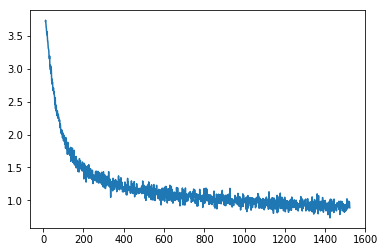

Accuracy :  76.29667519181585 %
Accuracy :  75.26086956521739 %


In [156]:
NN.gradient_plot()
NN.accuracy(X_train,y_train)
NN.accuracy(X_test,y_test)